In [1]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import json

#resnet18 = models.resnet18(pretrained=True)
model = models.mobilenet_v3_large(pretrained=True)

In [2]:
model

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=

In [3]:
model.classifier[3] = nn.Linear(1280, 13)

In [4]:
model.classifier[3].in_features

1280

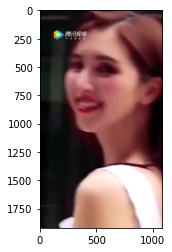

In [63]:
from PIL import Image
from matplotlib import pyplot as plt
img_root = '/data/flag/olympic/11045_1625851497502555.0.jpeg'   #10268_1625837044108050.5.jpeg'
img = Image.open(img_root)
plt.imshow(img)

In [43]:
w,h = img.size

In [64]:
import os
label_root = '/data/Detection_proj/yolov5-master/runs/detect/olympic_logo10/labels'
label_path = os.path.join(label_root,os.path.basename(img_root)[:-4]+'txt')
print(label_path)

/data/Detection_proj/yolov5-master/runs/detect/olympic_logo10/labels/11045_1625851497502555.0.txt


In [65]:
f = open(label_path)
labels = []
line = f.readline()
while line:
    print(line)
    labels.append(line.rstrip().split())
    line = f.readline()
f.close()
labels

10 0.154167 0.115365 0.0675926 0.0359375



[['10', '0.154167', '0.115365', '0.0675926', '0.0359375']]

In [46]:
line

'9 0.230556 0.220313 0.0537037 0.0229167\n'

In [66]:
img_label = np.array(labels,dtype=float)

In [67]:
import numpy as np
bbox = np.array(img_label[:,1:],dtype=float) * np.array([w,h,w,h])
bbox

array([[166.50036 , 221.5008  ,  73.000008,  69.      ]])

In [68]:
bbox_arr = np.zeros((bbox.shape[0],4))
print(bbox_arr)
bbox_arr[:,0] = bbox[:,0]-bbox[:,2]/2
bbox_arr[:,1] = bbox[:,1]-bbox[:,3]/2
bbox_arr[:,2] = bbox[:,0]+bbox[:,2]/2
bbox_arr[:,3] = bbox[:,1]+bbox[:,3]/2
bbox_arr

[[0. 0. 0. 0.]]


array([[130.000356, 187.0008  , 203.000364, 256.0008  ]])

In [35]:
weight = '/data/Detection_proj/resnet18_flag/weights/0719_mobilenet/best.pt'
model.load_state_dict(torch.load(weight)['model_state_dict'])

<All keys matched successfully>

[130.000356 187.0008   203.000364 256.0008  ]
tensor([3.3217e-06, 1.0978e-07, 2.5818e-06, 2.6986e-04, 3.9548e-06, 2.4861e-04,
        7.6000e-06, 1.7436e-05, 1.1789e-06, 2.2774e-06, 1.9972e-04, 9.9883e-01,
        4.1515e-04])
tensor(11)


/data/anaconda3/envs/map/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


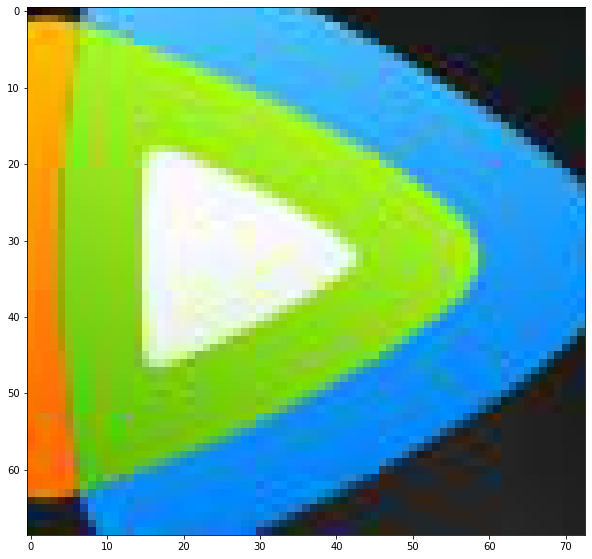

In [69]:
from PIL import Image
from PIL import ImageDraw
from matplotlib import pyplot as plt
import torch.nn.functional as F
import pdb
import os
from tqdm import tqdm


test_transform=transforms.Compose([
                transforms.Resize((112,112)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485,0.456,0.406],
                                     std=[0.229,0.224,0.225])
                                ])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
change = 0

for b in bbox_arr:
    print(b)
    img_crop = img.crop(b.tolist())
    plt.figure(figsize=(10,10))
    plt.imshow(img_crop)
    img_tensor = test_transform(img_crop)
    img_tensor = torch.unsqueeze(img_tensor,0)
    img_tensor = img_tensor.to(device)
    with torch.no_grad():
        output = model(img_tensor)

    pred = F.softmax(output.squeeze()).cpu()
    print(pred)
    cls = torch.argmax(pred)
    print(cls)

In [41]:
torch.tensor([[1,2,3,4,5,6,7]]) == torch.tensor([[1,2,3,4,5]])

RuntimeError: The size of tensor a (7) must match the size of tensor b (5) at non-singleton dimension 1

# 使用mobilenetv3过一遍yolo检测结果

In [5]:
weight = '/data/Detection_proj/resnet18_flag/weights/0719_mobilenet/best.pt'
model.load_state_dict(torch.load(weight)['model_state_dict'])

<All keys matched successfully>

In [16]:
data_root = '/data/flag/Images/images'
yolo_result = '/data/Detection_proj/yolov5-master/runs/test/final_test_expand_conf/best_predictions.json'
with open(yolo_result) as f:
    res = json.load(f)
res

[{'image_id': '/data/flag/test_dataset_label/images/ffout-i09381b3eeg/00907.jpg',
  'category_id': 0,
  'bbox': [172.868, 60.532, 25.326, 15.083],
  'score': 0.75331},
 {'image_id': '/data/flag/test_dataset_label/images/ffout-i09381b3eeg/00907.jpg',
  'category_id': 0,
  'bbox': [359.393, 196.331, 44.851, 39.512],
  'score': 0.52236},
 {'image_id': '/data/flag/test_dataset_label/images/ffout-i09381b3eeg/00907.jpg',
  'category_id': 6,
  'bbox': [171.934, 41.494, 27.553, 15.41],
  'score': 0.36735},
 {'image_id': '/data/flag/test_dataset_label/images/ffout-i09381b3eeg/00907.jpg',
  'category_id': 0,
  'bbox': [172.108, 40.99, 26.693, 15.863],
  'score': 0.34165},
 {'image_id': '/data/flag/test_dataset_label/images/ffout-i09381b3eeg/00907.jpg',
  'category_id': 0,
  'bbox': [173.098, 48.591, 25.508, 25.74],
  'score': 0.22003},
 {'image_id': '/data/flag/test_dataset_label/images/ffout-i09381b3eeg/01339.jpg',
  'category_id': 0,
  'bbox': [361.335, 356.744, 55.376, 113.533],
  'score': 0.

In [17]:
from PIL import Image
from PIL import ImageDraw
from matplotlib import pyplot as plt
import torch.nn.functional as F
import pdb
import os
from tqdm import tqdm


test_transform=transforms.Compose([
                transforms.Resize((112,112)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485,0.456,0.406],
                                     std=[0.229,0.224,0.225])
                                ])
clear_list = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
change = 0
for idx,it in enumerate(tqdm(res)):
    #pdb.set_trace()
    image_p = it['image_id']
    bbox = it['bbox']
    pred_cls = it['category_id']
    score = it['score']
    img_path = image_p
    img = Image.open(img_path)
    x1,y1,x2,y2 = int(bbox[0]),int(bbox[1]),int(bbox[0]+bbox[2]),int(bbox[1]+bbox[3])
    img_crop = img.crop((x1,y1,x2,y2))
    
    img_tensor = test_transform(img_crop)
    img_tensor = torch.unsqueeze(img_tensor,0)
    img_tensor = img_tensor.to(device)
    with torch.no_grad():
        output = model(img_tensor)
    
    pred = F.softmax(output.squeeze()).cpu()
    cls = torch.argmax(pred)
    
    if int(cls) == 11:
        #a = ImageDraw.ImageDraw(img)
        #a.rectangle(((x1,y1),(x2,y2)), fill=None, outline='red', width=5)  
        #plt.figure(figsize=(10,10))
        #plt.imshow(img)
        continue
    
    if int(cls) != pred_cls:
        change += 1

    #tmp = {'image_id':image_p,'category_id':int(cls),'bbox':bbox,'score':score}

    clear_list.append(it)
    #if int(cls) == pred_cls:
    #    continue
    #else:
    #    res[idx]['category_id'] = int(cls)   
    #print(pred)

#score_2 表示用detector的score，且把分类器的阈值调高，低于阈值的分类器认为是背景框
#with open('/data/Detection_proj/yolov5-master/runs/test/final_test7/best_predictions_resnet18_score2.json','w') as f:
#    json.dump(clear_list,f)    

100%|██████████| 6373/6373 [01:30<00:00, 70.69it/s]


In [18]:
len(clear_list)

4056

In [19]:
save_path = os.path.join(os.path.dirname(yolo_result),'best_predictions_clear.json')
#save_path
with open(save_path,'w') as f:
    json.dump(clear_list,f)

In [15]:
torch.zeros(0,5,dtype=bool)

tensor([], size=(0, 5), dtype=torch.bool)

In [26]:
test = [('a',1),('b',2),('c',3)]
test2 = [i for i in zip(*test)]
test2

[('a', 'b', 'c'), (1, 2, 3)]

In [29]:
np.maximum.accumulate([1,0.9,0.8,0.7,1.2])

array([1. , 1. , 1. , 1. , 1.2])

# 使用trained resnet18将yolov5的结果进行一遍过滤

In [2]:
fc_inputs = resnet18.fc.in_features
resnet18.fc = nn.Linear(fc_inputs, 11)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
weights = '/data/Detection_proj/resnet18_flag/weights/best.pt'
resnet18 = torch.load(weights)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
resnet18.fc

Linear(in_features=512, out_features=11, bias=True)

In [13]:
data_root = '/data/flag/test_dataset_label/images'
yolo_result = '/data/Detection_proj/yolov5-master/runs/test/final_test7/best_predictions.json'
with open(yolo_result) as f:
    res = json.load(f)
res

[{'image_id': 'ffout-i09381b3eeg/01006.jpg',
  'category_id': 0,
  'bbox': [172.817, 60.044, 25.232, 15.426],
  'score': 0.79544},
 {'image_id': 'ffout-i09381b3eeg/01006.jpg',
  'category_id': 6,
  'bbox': [171.904, 40.452, 27.487, 16.492],
  'score': 0.65172},
 {'image_id': 'ffout-i09381b3eeg/01006.jpg',
  'category_id': 10,
  'bbox': [172.188, 40.137, 26.352, 16.726],
  'score': 0.52368},
 {'image_id': 'ffout-i09381b3eeg/01006.jpg',
  'category_id': 0,
  'bbox': [172.772, 46.307, 25.544, 26.295],
  'score': 0.25446},
 {'image_id': 'ffout-i09381b3eeg/01006.jpg',
  'category_id': 10,
  'bbox': [172.772, 46.307, 25.544, 26.295],
  'score': 0.06822},
 {'image_id': 'ffout-i09381b3eeg/01006.jpg',
  'category_id': 0,
  'bbox': [407.245, 305.887, 23.231, 22.254],
  'score': 0.06037},
 {'image_id': 'ffout-i09381b3eeg/01006.jpg',
  'category_id': 10,
  'bbox': [172.56, 59.884, 25.305, 15.704],
  'score': 0.03961},
 {'image_id': 'ffout-i09381b3eeg/01006.jpg',
  'category_id': 0,
  'bbox': [252.

In [15]:
from PIL import Image
import torch.nn.functional as F
import pdb
import os
from tqdm import tqdm
test_transform=transforms.Compose([
                transforms.Resize((112,112)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485,0.456,0.406],
                                     std=[0.229,0.224,0.225])
                                ])
clear_list = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
resnet18.eval()
change = 0
for idx,it in enumerate(tqdm(res)):
    #pdb.set_trace()
    image_p = it['image_id']
    bbox = it['bbox']
    pred_cls = it['category_id']
    score = it['score']
    img_path = os.path.join(data_root,image_p)
    img = Image.open(img_path)
    x1,y1,x2,y2 = int(bbox[0]),int(bbox[1]),int(bbox[0]+bbox[2]),int(bbox[1]+bbox[3])
    img = img.crop((x1,y1,x2,y2))
    
    img = test_transform(img)
    img = torch.unsqueeze(img,0)
    img = img.to(device)
    with torch.no_grad():
        output = resnet18(img)
    
    pred = F.softmax(output.squeeze()).cpu()
    cls = torch.argmax(pred)
    
    #print(cls,' ',float(pred[int(cls)]))
    if float(pred[int(cls)]) > 0.7:
        if int(cls) != pred_cls:
            change += 1
        #tmp = {'image_id':image_p,'category_id':int(cls),'bbox':bbox,'score':float(pred[int(cls)])}
        tmp = {'image_id':image_p,'category_id':int(cls),'bbox':bbox,'score':score}
    
    clear_list.append(tmp)
    #if int(cls) == pred_cls:
    #    continue
    #else:
    #    res[idx]['category_id'] = int(cls)   
    #print(pred)

#score_2 表示用detector的score，且把分类器的阈值调高，低于阈值的分类器认为是背景框
with open('/data/Detection_proj/yolov5-master/runs/test/final_test7/best_predictions_resnet18_score2.json','w') as f:
    json.dump(clear_list,f)    

100%|██████████| 61920/61920 [34:02<00:00, 30.31it/s]


In [13]:
clear_list

[{'image_id': 'ffout-i09381b3eeg/01006.jpg',
  'category_id': 0,
  'bbox': [172.817, 60.044, 25.232, 15.426],
  'score': 0.9974666833877563},
 {'image_id': 'ffout-i09381b3eeg/01006.jpg',
  'category_id': 6,
  'bbox': [171.904, 40.452, 27.487, 16.492],
  'score': 0.5540964007377625},
 {'image_id': 'ffout-i09381b3eeg/01006.jpg',
  'category_id': 10,
  'bbox': [172.188, 40.137, 26.352, 16.726],
  'score': 0.5011981129646301},
 {'image_id': 'ffout-i09381b3eeg/01006.jpg',
  'category_id': 10,
  'bbox': [172.772, 46.307, 25.544, 26.295],
  'score': 0.8303048610687256},
 {'image_id': 'ffout-i09381b3eeg/01006.jpg',
  'category_id': 10,
  'bbox': [172.772, 46.307, 25.544, 26.295],
  'score': 0.8303048610687256},
 {'image_id': 'ffout-i09381b3eeg/01006.jpg',
  'category_id': 0,
  'bbox': [407.245, 305.887, 23.231, 22.254],
  'score': 0.9710496068000793},
 {'image_id': 'ffout-i09381b3eeg/01006.jpg',
  'category_id': 0,
  'bbox': [172.56, 59.884, 25.305, 15.704],
  'score': 0.9972953200340271},
 {'

In [14]:
change

43701

In [15]:
with open('/data/Detection_proj/yolov5-master/runs/test/final_test7/best_predictions_resnet18_score.json','w') as f:
    json.dump(clear_list,f)

In [16]:
iouv = torch.linspace(0.5, 0.95, 10).to(device)  # iou vector for mAP@0.5:0.95
niou = iouv.numel()

10

In [17]:
iouv

tensor([0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500, 0.9000,
        0.9500], device='cuda:0')

In [18]:
correct = torch.zeros(3, niou, dtype=torch.bool)
correct

tensor([[False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False]])

# 测试训练好的resent18

In [10]:
valid_data_size = len(testset)
import os
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to('cuda:0')
valid_loss = 0.0
valid_acc = 0.0

with torch.no_grad():
    resnet18.eval()

    for j, (inputs, labels) in enumerate(testloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = resnet18(inputs)

        #loss = criterion(outputs, labels)

        #valid_loss += loss.item() * inputs.size(0)

        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        acc = torch.mean(correct_counts.type(torch.FloatTensor))

        valid_acc += acc.item() * inputs.size(0)


avg_valid_loss = valid_loss/valid_data_size
avg_valid_acc = valid_acc/valid_data_size

In [11]:
avg_valid_acc

0.9319197665420415

# 训练resnet18

In [ ]:
fc_inputs = resnet18.fc.in_features
resnet18.fc = nn.Linear(fc_inputs, 11)
resnet18

In [8]:
import os
import json
from tqdm import tqdm
ann_files = ['flag_ann_train_all.json','flag_ann_val_all.json','flag_ann_test_all.json']
save_files = ['flag_classify_train.json','flag_classify_val.json','flag_classify_test.json']
root = '/data/flag'
classify = []
for idx,ann in enumerate(ann_files):
    ann_path = os.path.join(root,ann)
    save_path = os.path.join(root,save_files[idx])
    with open(ann_path) as f:
        ann_file = json.load(f)
    for it in tqdm(ann_file):
        img_path = it['image_path']
        annotation = it['annotation']
        for ann_it in annotation:
            class_id = ann_it['class_id']
            bbox = ann_it['bbox']
            tmp = (img_path,float(class_id),(bbox[0][0],bbox[0][1],bbox[1][0],bbox[1][1]))
            classify.append(tmp)
    with open(save_path,'w') as f:
        json.dump(classify,f)
    #assert 0

100%|██████████| 728/728 [00:00<00:00, 191043.82it/s]


In [22]:
import matplotlib.pyplot as plt
from PIL import Image
data_root = '/data/flag/Images/images'
save_root = '/data/flag/crop_flag'
import pdb
for idx,it in enumerate(classify):
    img_path,_,bbox = it
    save_path = os.path.join(save_root,img_path)
    
    img_path  = os.path.join(data_root,img_path)
    
    #pdb.set_trace()
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))
    img = Image.open(img_path)
    img_crop = img.crop(bbox)
    img_crop = img_crop.resize((224,224))
    img_crop.save(save_path)
    #plt.imshow(img_crop)
    if idx > 200:
        break
#assert 0

In [15]:
save_path

'/data/flag/Images/images/ffout-18/00597.jpg'

In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import json
from PIL import Image
class flag_dataset(Dataset):
    def __init__(self, data_root,annotations_file, transform=None):
        super(flag_dataset,self).__init__()
        self.data_root = data_root
        #self.img_labels = pd.read_csv(annotations_file)
        with open(annotations_file) as f:
            self.train_file = json.load(f)
        self.transform = transform
        
    def __len__(self):
        return len(self.train_file)

    def __getitem__(self, idx):
        rela_path,label,bbox = self.train_file[idx]
        img_path = os.path.join(self.data_root,rela_path)
        image = Image.open(img_path)
        #(left, upper, right, lower) = (20, 20, 100, 100)
        #im_crop = im.crop((left, upper, right, lower))
        image_crop = image.crop(bbox)
        if self.transform:
            #print('do transformation...')
            image_crop = self.transform(image_crop)
        return image_crop, int(label)

In [5]:
train_transform=transforms.Compose([
            transforms.Resize((112,112)),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])
                            ])

test_transform=transforms.Compose([
            transforms.Resize((112,112)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])
                            ])

batch_size = 8

data_root = '/data/flag/Images/images'
train_ann_file = '/data/flag/flag_classify_train.json'
val_ann_file = '/data/flag/flag_classify_val.json'

trainset = flag_dataset(data_root,train_ann_file,train_transform)
testset = flag_dataset(data_root,val_ann_file,test_transform)
trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('china','us','uk','russia','japan','france','german','italy','australia','korea','other')

do transformation...
do transformation...
do transformation...
do transformation...
do transformation...
do transformation...
do transformation...
do transformation...
do transformation...
do transformation...
do transformation...
do transformation...
do transformation...
do transformation...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


do transformation...
do transformation...
do transformation...
do transformation...
do transformation...
do transformation...


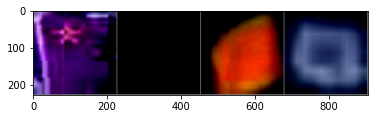

china other china korea


In [43]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

23845

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=[20,40],gamma = 0.1)

In [8]:
import os
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to('cuda:0')
history = []
best_acc = 0.0
best_epoch = 0
valid_data_size = len(testset)
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    valid_loss = 0.0
    valid_acc = 0.0
    resnet18.train()
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
            
            with torch.no_grad():
                resnet18.eval()

                for j, (inputs, labels) in enumerate(testloader):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = resnet18(inputs)

                    loss = criterion(outputs, labels)

                    valid_loss += loss.item() * inputs.size(0)

                    ret, predictions = torch.max(outputs.data, 1)
                    correct_counts = predictions.eq(labels.data.view_as(predictions))

                    acc = torch.mean(correct_counts.type(torch.FloatTensor))

                    valid_acc += acc.item() * inputs.size(0)


            avg_valid_loss = valid_loss/valid_data_size
            avg_valid_acc = valid_acc/valid_data_size
            print('val loss',avg_valid_loss)
            print('val acc',avg_valid_acc)


    if best_acc < avg_valid_acc:
        best_acc = avg_valid_acc
        best_epoch = epoch + 1
        torch.save(resnet18, os.path.join('/data/Detection_proj/resnet18_flag/weights','best.pt'))


    print("Epoch: {:03d}  Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(
        epoch+1, avg_valid_loss, avg_valid_acc*100
    ))

print("Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))
print('Finished Training')

[1,    20] loss: 1.864
val loss 1.6734793772359167
val acc 0.5628162978849951
[1,    40] loss: 1.455


KeyboardInterrupt: 

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))